In [2]:
#libraries
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parents[0]) 

In [3]:
pwd

'/mnt/c/Users/maxpu/Dropbox/scripts/Projects/abstraction'

In [33]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
# from STOMPnet import STOMPnet,Decoder
# from STOMPnet2 import STOMPnet2
# from utils import MultiChannelNet, get_width, count_parameters
from models import get_width
import h5py
import yaml
import json
import hashlib
import wandb
from types import SimpleNamespace
import seaborn as sns
from models import STOMP
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [116]:
def get_runs():
    api = wandb.Api()
    runs = api.runs("TOMMM")
    summary_list, logged_vars_list, config_list, name_list, state_list = [], [], [], [], []
    for run in runs:
#         if run.group=='scaling-nointer' or run.group=='scaling':
        if run.group=='postICML':
            
            # .summary contains output keys/values for
            # metrics such as accuracy.
            #  We call ._json_dict to omit large files
            summary_list.append(run.summary._json_dict)
            
            # .history() contains a dataframe indexed by epoch of logged variables
            logged_vars_list.append(run.history())
            
            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append({k: v for k, v in run.config.items()}) # if not k.startswith("_")})

            # .name is the human-readable name of the run.
            name_list.append(run.name)

            state_list.append(run.state)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "logged_vars": logged_vars_list, "config": config_list, "name": name_list, "state": state_list}
    )

#     runs_df.to_csv("project.csv")
#     runs_df.loc[:,['state','config']].apply(lambda run: run.state+
#                                            ': N'+str(run.config['num_agents'])+
#                                            ', P'+str(run.config['P'])+
#                                            ' '+run.config['model_name'] if run.state=='finished' else run.state,axis=1)
    return runs_df
runs_df=get_runs()

data
{
    "corr": 0,
    "hash": "6c56fb91e3",
    "model_name": "logit",
    "num_actions": 2,
    "num_agents": 10,
    "num_test_samples": 10000,
    "num_train_samples": 10000,
    "outdir": "output/",
    "state_dim": 8,
    "timestamp": "20240731_130257"
}
train
{
    "P": 500000,
    "batch_size": 8,
    "data_dir": "data_6c56fb91e3",
    "data_seed": 0,
    "hash": "0cd087d35e",
    "learning_rate": 0.0005011313655009896,
    "model_settings": {
        "decoder_type": "MLP",
        "inter_model_type": "ipattn",
        "model_name": "STOMP",
        "seq_len": 16
    },
    "num_epochs": 50,
    "outdir": "output/",
    "seed": 0
}
model
{
    "P": 500000,
    "Pactual": 599078,
    "dec_hidden_dim": 172,
    "decoder_type": "MLP",
    "enc_MLPhidden_dim": 172,
    "enc_hidden_dim": 172,
    "enc_out_dim": 172,
    "inter_model_type": "ipattn",
    "model_name": "STOMP",
    "num_actions": 2,
    "num_agents": 10,
    "seq_len": 16,
    "state_dim": 8
}
enc_hidden/enc_out di

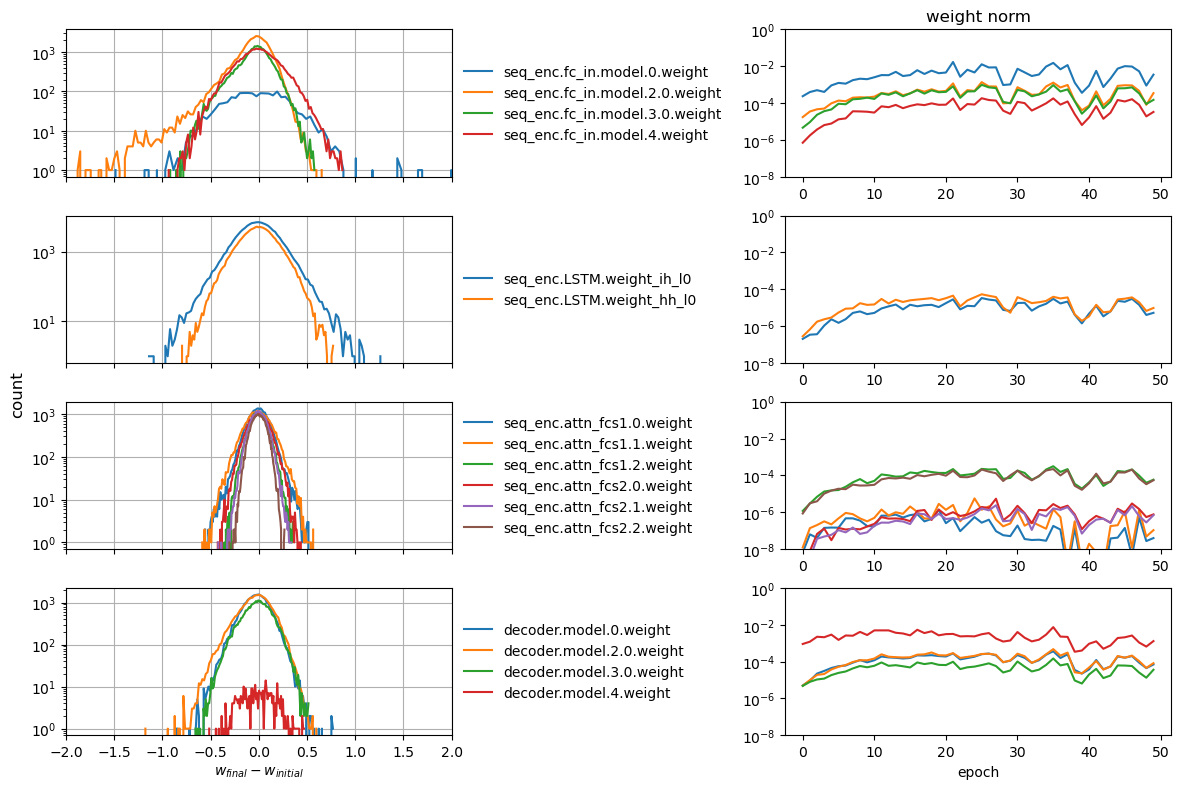

In [120]:
#get load data
cond = 0
run = runs_df.iloc[cond]
config = run.config
data_hash =config['data_hash'][5:]
train_hash = config['hash']
outdir = 'output/'
data_dir = f'data_{data_hash}/'
data_filename = os.path.join(outdir, data_dir, 'data.h5')
config_filename = os.path.join(outdir, data_dir, 'config.yaml')
save_dir = os.path.join(outdir, data_dir, 'training_results/')
train_info_dir = os.path.join(save_dir, train_hash)
with open(config_filename, 'r') as f:
    print('data')
    data_config = yaml.load(f, Loader=yaml.FullLoader)
    print(json.dumps(data_config['file_attrs'],sort_keys=True, indent=4))
    data_config = SimpleNamespace(**data_config)
with open(train_info_dir + "/train_config.yaml", 'r') as f:
    print('train')
    train_config = yaml.load(f, Loader=yaml.FullLoader)
    print(json.dumps(train_config,sort_keys=True, indent=4))
    train_config = SimpleNamespace(**train_config)
with open(train_info_dir + "/model_config.yaml", 'r') as f:
    print('model')
    model_config = yaml.load(f, Loader=yaml.FullLoader)
    print(json.dumps(model_config,sort_keys=True, indent=4))
    model_config = SimpleNamespace(**model_config)

results = pd.read_csv(train_info_dir + "/results.csv")
wandb_results = run.logged_vars
state_dict_final = torch.load(train_info_dir + "/state_dict_final.pt")

set_seed(train_config.seed)
model = STOMP(model_config)
untrained_state_dict=model.state_dict()
print("Model's state_dict:")
for name, layer in model.named_modules():
    print(name)

fig,ax=pl.subplots(4,2,figsize=(12,4*2))
module_name_list = ['seq_enc.fc_in', 'seq_enc.LSTM', 'seq_enc.attn', 'decoder.model']
for param_tensor in untrained_state_dict:
    if 'weight' in param_tensor:
        hist=torch.histogram((state_dict_final[param_tensor]-untrained_state_dict[param_tensor]).flatten())
        for mit, module_name in enumerate(module_name_list):
            if module_name in param_tensor:
                ax[mit,0].plot(hist.bin_edges[:-1], hist.hist,label=param_tensor)
                ax[mit,1].plot(results[param_tensor],label=param_tensor)
for ait,axt in enumerate(ax[:,0]):
    axt.set_yscale('log')
    if ait<3:
        axt.set_xticklabels([])
    axt.set_xlim(-2,2)
    axt.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
    axt.grid(True)
    ax[ait,1].set_yscale('log')
    ax[ait,1].set_ylim(1e-8,1e0)

# for name, gradnorm in wandb_results['allgradnorms'].items():
#      for mit, module_name in enumerate(module_name_list):
#         if module_name in param_tensor:
#             ax[mit,1].plot(wandb_results[module_name],label=module_name)
ax[len(module_name_list)-1,0].set_xlabel(r'$w_{final} - w_{initial}$')
ax[0,1].set_title('weight norm')
ax[len(module_name_list)-1,1].set_xlabel('epoch')
fig.supylabel('count')
fig.tight_layout()
# for param_tensor in untrained_state_dict:
#     print(param_tensor, "\t", untrained_state_dict[param_tensor].size())
# for name, param in untrainedmodel.named_parameters():
#     print(f"{name} {param.shape}")
# weights = 
# print()
# for param_tensor in state_dict_final:
#     print(param_tensor, "\t", state_dict_final[param_tensor].size())
# model.load_state_dict(state_dict_final)
# #load checkpoints
# state_dict_checkpoints = [torch.load(train_info_dir + f"/state_dict_{epoch}.pt") 
#                           for epoch in range(5,training_args['epochs']+1,5)]
# load the hdf data (one file for each seed)
# with h5py.File(data_filename, 'r') as f:
#     datasets = {}
#     for group_name, group in f.items():
#         datasets[group_name] = {key: np.array(
#             value) for key, value in group.items()}

In [30]:
runs_df.summary[0]['test_accuracy']

0.7849154664415801

In [22]:
runs_df.name[0]

'N1000_P371792_l32_c0.8_lr0.0005_imNone_dtMLP'

In [26]:
runs_df.config[0]['corr']
runs_df.config[0]['num_agents']
runs_df.config[0]['Pactual']
run_df.group=='scaling-nointer'

371792

In [11]:
api = wandb.Api()
runs = api.runs("TOMMM")

In [16]:
 summary_list, config_list, name_list, state_list = [], [], [], []
for run in runs:
    if 
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items()}) # if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    state_list.append(run.state)

'scaling-nointer'

In [99]:
def get_runs():
    api = wandb.Api()
    runs = api.runs("TOMMM")
    df_list = []
    for run in runs:
        print(run.summary)
        if run.group=='scaling-nointer' or run.group=='scaling':
            try:
                if run.summary['epoch']>10:
                    dict_tmp={
                        "arch": run.group,
                        "corr": run.config['corr'],
                        "N": run.config['num_agents'],
                        "P": run.config['Pactual'],
                        "test_accuracy": run.summary['test_accuracy']
                    }
                    df_list.append(dict_tmp)
            except:
                print('failed')
    runs_df = pd.DataFrame(df_list)

#     runs_df.to_csv("project.csv")
#     runs_df.loc[:,['state','config']].apply(lambda run: run.state+
#                                            ': N'+str(run.config['num_agents'])+
#                                            ', P'+str(run.config['P'])+
#                                            ' '+run.config['model_name'] if run.state=='finished' else run.state,axis=1)
    return runs_df
runs_df=get_runs()

{'enc_gradnorm': 542.0419311523438, 'test_accuracy': 0.7849154664415801, 'train_accuracy': 0.9050482966448292, '_step': 76, 'epoch': 76, 'dec_gradnorm': 218.0572967529297, 'test_loss_per_agent': 0.6780844961444983, 'train_loss_per_agent': 0.22035458210536413, '_runtime': 86169.27777004242, '_timestamp': 1720824263.346508}
{'_step': 73, 'epoch': 73, '_runtime': 86288.21161222458, 'train_accuracy': 0.9061399904912396, '_timestamp': 1720824160.8939185, 'dec_gradnorm': 949.8303833007812, 'enc_gradnorm': 621.2056884765625, 'test_accuracy': 0.8837228554688142, 'test_loss_per_agent': 0.33024716806182125, 'train_loss_per_agent': 0.24859066572847563}
{'dec_gradnorm': 46.13778305053711, 'test_accuracy': 0.8434038731010921, 'train_accuracy': 0.9921859807512732, 'train_loss_per_agent': 0.02695653850945194, '_step': 99, '_timestamp': 1720738065.7108395, '_runtime': 11904.123713493347, 'enc_gradnorm': 194.23377990722656, 'test_loss_per_agent': 0.7793221065684268, 'epoch': 99, '_wandb': {'runtime': 1

{'_step': 5, 'enc_gradnorm': 0, 'test_loss_per_agent': 0.6926821201275557, 'train_accuracy': 0.5159555278861752, 'train_loss_per_agent': 0.6926706405404286, 'epoch': 5, '_wandb': {'runtime': 513}, '_runtime': 467.11192655563354, '_timestamp': 1720396286.2549915, 'dec_gradnorm': 1.0652897357940674, 'test_accuracy': 0.5153946312239919}
{'_wandb': {'runtime': 801}, '_runtime': 747.000363111496, '_timestamp': 1720395727.2950432, 'test_accuracy': 0.5786858969965042, '_step': 10, 'dec_gradnorm': 1.4731624126434326, 'enc_gradnorm': 3.52224063873291, 'train_accuracy': 0.5945112176526052, 'test_loss_per_agent': 0.6686280927214867, 'train_loss_per_agent': 0.6606622503353999, 'epoch': 10}
{'_runtime': 5203.20202589035, 'dec_gradnorm': 0.4686622619628906, 'train_accuracy': 0.9939403077348684, 'test_loss_per_agent': 0.5218745969580666, 'train_loss_per_agent': 0.018916631788996687, 'epoch': 99, '_wandb': {'runtime': 5234}, '_timestamp': 1720394092.1315029, 'enc_gradnorm': 10.264018058776855, 'test_a

In [43]:
runs_df

,group,corr,N,P,test_accuracy
0,scaling-nointer,0.8,1000,371792,0.784915
1,scaling-nointer,0.0,1000,371792,0.883723
2,scaling,0.0,1000,5683358,0.967938
3,scaling,0.8,1000,531848,0.767937
4,scaling,0.8,100,5683358,0.501081
5,scaling,0.8,100,531848,0.816939
6,scaling,0.0,100,5683358,0.958644
7,scaling,0.0,100,531848,0.965128
8,scaling,0.0,10,531848,0.846368


In [65]:
import seaborn as sns

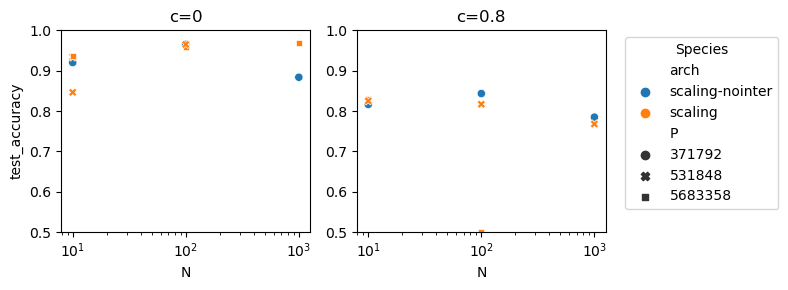

In [100]:
fig,ax=pl.subplots(1,2,figsize=(8,3))
mrkvec=['o','x']
for cit,corr in enumerate([0,0.8]):
#     for git,group_name in enumerate(['scaling','scaling_nointer']):
    g=sns.scatterplot(
        data=runs_df.loc[(runs_df['corr'] == corr),:], 
        x='N', 
        y='test_accuracy', 
        hue='arch',
        style='P',
        ax=ax[cit],
    )
    if cit==1:
        sns.move_legend(g, "upper left", bbox_to_anchor=(1.05, 1), title='Species')
#     ax[cit].legend(False)
    ax[cit].set_ylim(0.5,1)
    ax[cit].set_xscale('log')
    ax[cit].set_title('c='+str(corr))
ax[0].legend([],[], frameon=False)
ax[1].set_ylabel('')
fig.tight_layout()